In [2]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt 
tfds.disable_progress_bar()

In [3]:
#Helper Function to plot graph
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

 IMDB large movie review dataset is a binary classification dataset—all the reviews have either a positive or negative sentiment.     
 Source: https://www.tensorflow.org/datasets/catalog/imdb_reviews

In [4]:
dataset, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete55HSKT/imdb_reviews-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete55HSKT/imdb_reviews-test.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete55HSKT/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [5]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


In [6]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [7]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [8]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b"Cypher is a clever, effective and eerie film that delivers. Its good premise is presented well and it has its content delivered in an effective manner but also in a way the genre demands. Although one could immediately label the film a science fiction, there is a little more to it. It has it's obvious science fiction traits but the film resembles more of a noir/detective feel than anything else which really adds to the story.<br /><br />The film, overall, plays out like it's some kind of nightmare; thus building and retaining a good atmosphere. We're never sure of what exactly is going on, we're never certain why certain things that are happening actually are and we're not entirely sure of certain people, similar to having a dream \xc2\x96 the ambiguity reigns over us all \xc2\x96 hero included and I haven't seen this pulled off in such a manner in a film before, bar Terry Gilliam's Brazil. Going with the eeriness stated earlier, Cypher presents itself with elements of horro

**Text Encoder**: Data processing

In [9]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [10]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [11]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[  1,   7,   4, ...,   0,   0,   0],
       [ 10, 199, 438, ...,   0,   0,   0],
       [ 10, 479,  11, ...,   0,   0,   0]])

In [12]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b"Cypher is a clever, effective and eerie film that delivers. Its good premise is presented well and it has its content delivered in an effective manner but also in a way the genre demands. Although one could immediately label the film a science fiction, there is a little more to it. It has it's obvious science fiction traits but the film resembles more of a noir/detective feel than anything else which really adds to the story.<br /><br />The film, overall, plays out like it's some kind of nightmare; thus building and retaining a good atmosphere. We're never sure of what exactly is going on, we're never certain why certain things that are happening actually are and we're not entirely sure of certain people, similar to having a dream \xc2\x96 the ambiguity reigns over us all \xc2\x96 hero included and I haven't seen this pulled off in such a manner in a film before, bar Terry Gilliam's Brazil. Going with the eeriness stated earlier, Cypher presents itself with elements of hor

**Model Creation**

In [13]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [14]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [15]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

[0.01563608]


In [16]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

[0.01563608]


In [17]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), optimizer=tf.keras.optimizers.Adam(1e-4), metrics=['accuracy'])

**Training**

In [18]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 108s 251ms/step - loss: 0.6715 - accuracy: 0.5387 - val_loss: 0.6697 - val_accuracy: 0.5188
Epoch 2/10
391/391 [==============================] - 93s 235ms/step - loss: 0.5393 - accuracy: 0.7161 - val_loss: 0.4421 - val_accuracy: 0.7922
Epoch 3/10
391/391 [==============================] - 92s 233ms/step - loss: 0.3918 - accuracy: 0.8204 - val_loss: 0.3700 - val_accuracy: 0.8276
Epoch 4/10
391/391 [==============================] - 92s 232ms/step - loss: 0.3499 - accuracy: 0.8443 - val_loss: 0.3422 - val_accuracy: 0.8500
Epoch 5/10
391/391 [==============================] - 92s 234ms/step - loss: 0.3285 - accuracy: 0.8572 - val_loss: 0.3375 - val_accuracy: 0.8625
Epoch 6/10
391/391 [==============================] - 93s 236ms/step - loss: 0.3190 - accuracy: 0.8620 - val_loss: 0.3252 - val_accuracy: 0.8604
Epoch 7/10
391/391 [==============================] - 92s 233ms/step - loss: 0.3110 - accuracy: 0.8668 - val_loss: 0.3221 - val_a

In [19]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 48s 124ms/step - loss: 0.3165 - accuracy: 0.8604
Test Loss: 0.31654641032218933
Test Accuracy: 0.8604400157928467


(0.0, 0.6899769470095635)

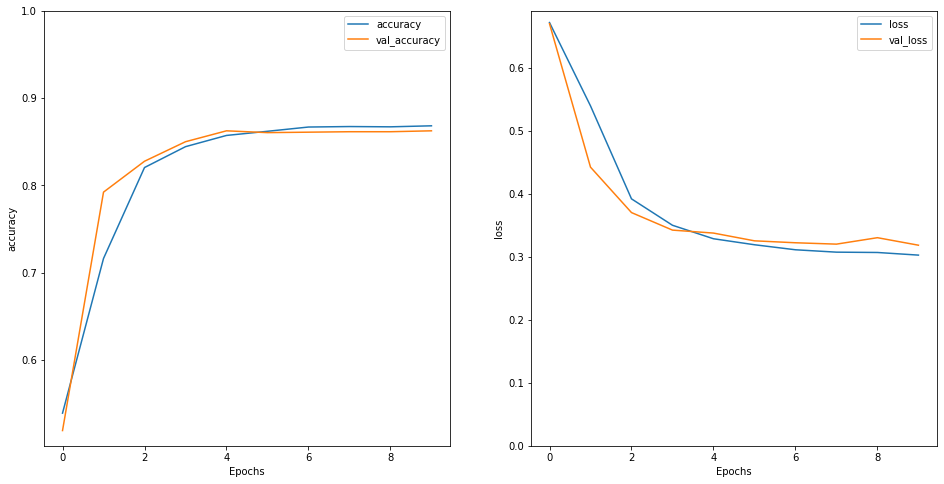

In [20]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

**prediction >= 0.0, implies positive else it is negative.**

In [21]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

In [22]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [23]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [24]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 197s 456ms/step - loss: 0.6452 - accuracy: 0.5567 - val_loss: 0.4762 - val_accuracy: 0.7875
Epoch 2/10
391/391 [==============================] - 170s 433ms/step - loss: 0.4108 - accuracy: 0.8221 - val_loss: 0.3650 - val_accuracy: 0.8365
Epoch 3/10
391/391 [==============================] - 168s 427ms/step - loss: 0.3473 - accuracy: 0.8535 - val_loss: 0.3375 - val_accuracy: 0.8505
Epoch 4/10
391/391 [==============================] - 170s 432ms/step - loss: 0.3231 - accuracy: 0.8633 - val_loss: 0.3253 - val_accuracy: 0.8505
Epoch 5/10
391/391 [==============================] - 167s 426ms/step - loss: 0.3159 - accuracy: 0.8676 - val_loss: 0.3186 - val_accuracy: 0.8510
Epoch 6/10
391/391 [==============================] - 167s 425ms/step - loss: 0.3083 - accuracy: 0.8690 - val_loss: 0.3171 - val_accuracy: 0.8557
Epoch 7/10
391/391 [==============================] - 169s 429ms/step - loss: 0.3045 - accuracy: 0.8736 - val_loss: 0.3337 -

In [25]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 82s 211ms/step - loss: 0.3135 - accuracy: 0.8624
Test Loss: 0.3135310113430023
Test Accuracy: 0.8624399900436401


In [26]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

[[-2.016715]]


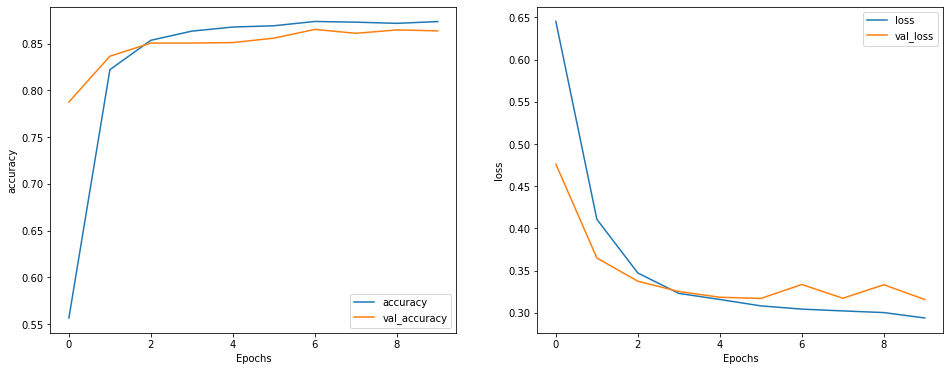

In [27]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')